# Import Library

In [32]:
import pandas as pd
import numpy as np
from lda import guidedlda as glda
import lda

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string

import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora, models

# Load Dataset

In [33]:
# Load the dataset
df = pd.read_csv('data/reviews.csv')  # Replace with your dataset path

In [34]:
df_negatif = df[df['label']=='Negative']

In [35]:
df_negatif

,Review,label,confidence
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813
9,verifikasi gagal,Negative,0.999831
10,sampah,Negative,0.999882
...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558


# Preprocessing

In [7]:
with open ('indonesian_stopword_1.txt', 'r') as file:
    indonesian_stop_words = [line.strip() for line in file.readlines()]

In [8]:
print("Stop Words:", indonesian_stop_words)

Stop Words: ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'b

In [9]:
df['Review'] = df['Review'].dropna()

In [10]:
def remove_stopwords(text, stopwords):
    words = text.split()
    words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(words)


In [11]:
df['clean_text'] = df['Review'].apply(lambda x: remove_stopwords(x, indonesian_stop_words))
print(df)

AttributeError: 'float' object has no attribute 'split'

In [ ]:
#menghapus kolom review label dan confidence
data = df.copy()
data = data.drop(columns=['Review', 'label', 'confidence'], axis=1)

In [ ]:
data

,clean_text
1,proses data dikirim validasi data data pembaya...
3,aplikasinya sihkok sim tulisannya layanan ters...
4,aplikasi payah duit dibayar muncul notifikasi ...
9,verifikasi gagal
10,sampah
...,...
33252,daftar tes psikotes gagal nik cek proses
33255,pengembangan tersedia bintang 1 sim 1 bintang ...
33256,aplikasinya butut orang login persulit otp uda...
33257,verifikasi nomor telepon masuk susah banget ya...


# Preprocessing Broo!

In [37]:
#hapus duplikatt
df_negatif = df_negatif.rename(columns={'Review' : 'review'})
df_negatif_nodup = df_negatif.drop_duplicates(subset='review')
df_negatif_nodup

,review,label,confidence
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813
9,verifikasi gagal,Negative,0.999831
10,sampah,Negative,0.999882
...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558


In [38]:
import re
#menghapus tanda baca
def hapus_tandabaca(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    return text

df_negatif_nodup['hapus_tandabaca'] = df_negatif_nodup['review'].apply(hapus_tandabaca)
df_negatif_nodup

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2370089010.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negatif_nodup['hapus_tandabaca'] = df_negatif_nodup['review'].apply(hapus_tandabaca)


,review,label,confidence,hapus_tandabaca
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...
9,verifikasi gagal,Negative,0.999831,verifikasi gagal
10,sampah,Negative,0.999882,sampah
...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...


In [39]:
#menghapus angka
def hapus_angka(text):
    text = re.sub(r'\d+', '', text)
    return text

df_negatif_nodup['hapus_angka'] = df_negatif_nodup['hapus_tandabaca'].apply(hapus_angka)
df_negatif_nodup

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\172100526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negatif_nodup['hapus_angka'] = df_negatif_nodup['hapus_tandabaca'].apply(hapus_angka)


,review,label,confidence,hapus_tandabaca,hapus_angka
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...
9,verifikasi gagal,Negative,0.999831,verifikasi gagal,verifikasi gagal
10,sampah,Negative,0.999882,sampah,sampah
...,...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...


In [40]:
#Menghapus URL dan emotikon
def hapus_url(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # URL
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # emotikon atau karakter non-ASCII
    return text

df_negatif_nodup['hapus_url'] = df_negatif_nodup['hapus_angka'].apply(hapus_url)
df_negatif_nodup

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2287361110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negatif_nodup['hapus_url'] = df_negatif_nodup['hapus_angka'].apply(hapus_url)


,review,label,confidence,hapus_tandabaca,hapus_angka,hapus_url
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...
9,verifikasi gagal,Negative,0.999831,verifikasi gagal,verifikasi gagal,verifikasi gagal
10,sampah,Negative,0.999882,sampah,sampah,sampah
...,...,...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...


In [41]:
#Tokenisasi
def tokenize(text):
    # Check if the input is a string, convert to string if not
    if not isinstance(text, str):
        text = str(text)
    return word_tokenize(text) #kurang pos tagging

df_negatif_nodup['tokenized'] = df_negatif_nodup['hapus_url'].apply(tokenize)
df_negatif_nodup

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\3475108074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negatif_nodup['tokenized'] = df_negatif_nodup['hapus_url'].apply(tokenize)


,review,label,confidence,hapus_tandabaca,hapus_angka,hapus_url,tokenized
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,"[harusnya, proses, itu, setelah, data, dikirim..."
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,"[ini, aplikasinya, kenapa, sihkok, mau, buat, ..."
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,"[aplikasi, payah, duit, sudah, dibayar, tapi, ..."
9,verifikasi gagal,Negative,0.999831,verifikasi gagal,verifikasi gagal,verifikasi gagal,"[verifikasi, gagal]"
10,sampah,Negative,0.999882,sampah,sampah,sampah,[sampah]
...,...,...,...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,"[pada, saat, daftar, tes, psikotes, gagal, ter..."
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,"[banyak, yang, masih, pengembangan, tidak, ter..."
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,"[aplikasinya, butut, orang, mau, login, saja, ..."
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,"[verifikasi, nomor, telepon, untuk, masuk, kok..."


In [42]:
import json
with open('data/combined_slang_words.txt', 'r', encoding='utf-8') as file:
    slang_dict = json.load(file)

# Fungsi normalisasi berdasarkan token list
def normalisasi(tokens, slang_dict):
    return [slang_dict.get(word.lower(), word) for word in tokens]

df_negatif_nodup['normalized'] = df_negatif_nodup['tokenized'].apply(lambda x: normalisasi(x, slang_dict))
df_negatif_nodup

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\106399845.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negatif_nodup['normalized'] = df_negatif_nodup['tokenized'].apply(lambda x: normalisasi(x, slang_dict))


,review,label,confidence,hapus_tandabaca,hapus_angka,hapus_url,tokenized,normalized
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,"[harusnya, proses, itu, setelah, data, dikirim...","[harusnya, proses, itu, setelah, data, dikirim..."
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,"[ini, aplikasinya, kenapa, sihkok, mau, buat, ...","[ini, aplikasinya, kenapa, sihkok, mau, buat, ..."
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,"[aplikasi, payah, duit, sudah, dibayar, tapi, ...","[aplikasi, payah, duit, sudah, dibayar, tapi, ..."
9,verifikasi gagal,Negative,0.999831,verifikasi gagal,verifikasi gagal,verifikasi gagal,"[verifikasi, gagal]","[verifikasi, gagal]"
10,sampah,Negative,0.999882,sampah,sampah,sampah,[sampah],[sampah]
...,...,...,...,...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,"[pada, saat, daftar, tes, psikotes, gagal, ter...","[pada, saat, daftar, tes, psikotes, gagal, ter..."
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,"[banyak, yang, masih, pengembangan, tidak, ter...","[banyak, yang, masih, pengembangan, tidak, ter..."
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,"[aplikasinya, butut, orang, mau, login, saja, ...","[aplikasinya, butut, orang, mau, login, saja, ..."
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,"[verifikasi, nomor, telepon, untuk, masuk, kok...","[verifikasi, nomor, telepon, untuk, masuk, kok..."


In [43]:
# Load stopword dari file
with open('indonesian_stopword_1.txt', 'r', encoding='utf-8') as file:
    indonesian_stop_words = set([line.strip().lower() for line in file])

def hapus_stopwords(tokens, stopwords):
    return [word for word in tokens if word.lower() not in stopwords]

df_negatif_nodup['stop_word'] = df_negatif_nodup['normalized'].apply(lambda x: hapus_stopwords(x, indonesian_stop_words))
df_negatif_nodup

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\920663216.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negatif_nodup['stop_word'] = df_negatif_nodup['normalized'].apply(lambda x: hapus_stopwords(x, indonesian_stop_words))


,review,label,confidence,hapus_tandabaca,hapus_angka,hapus_url,tokenized,normalized,stop_word
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,"[harusnya, proses, itu, setelah, data, dikirim...","[harusnya, proses, itu, setelah, data, dikirim...","[proses, data, dikirim, validasi, data, data, ..."
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,"[ini, aplikasinya, kenapa, sihkok, mau, buat, ...","[ini, aplikasinya, kenapa, sihkok, mau, buat, ...","[aplikasinya, sihkok, sim, tulisannya, layanan..."
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,"[aplikasi, payah, duit, sudah, dibayar, tapi, ...","[aplikasi, payah, duit, sudah, dibayar, tapi, ...","[aplikasi, payah, duit, dibayar, muncul, notif..."
9,verifikasi gagal,Negative,0.999831,verifikasi gagal,verifikasi gagal,verifikasi gagal,"[verifikasi, gagal]","[verifikasi, gagal]","[verifikasi, gagal]"
10,sampah,Negative,0.999882,sampah,sampah,sampah,[sampah],[sampah],[sampah]
...,...,...,...,...,...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,"[pada, saat, daftar, tes, psikotes, gagal, ter...","[pada, saat, daftar, tes, psikotes, gagal, ter...","[daftar, tes, psikotes, gagal, nik, cek, proses]"
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,"[banyak, yang, masih, pengembangan, tidak, ter...","[banyak, yang, masih, pengembangan, tidak, ter...","[pengembangan, tersedia, bintang, sim, bintang..."
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,"[aplikasinya, butut, orang, mau, login, saja, ...","[aplikasinya, butut, orang, mau, login, saja, ...","[aplikasinya, butut, orang, login, persulit, o..."
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,"[verifikasi, nomor, telepon, untuk, masuk, kok...","[verifikasi, nomor, telepon, untuk, masuk, kok...","[verifikasi, nomor, telepon, masuk, susah, ban..."


# membuat bigram trigram

In [44]:
# Tokenisasi setiap teks menjadi list kata
sentences = df_negatif_nodup['stop_word'].to_list()

# Membuat bigram dan trigram model
bigram = Phrases(sentences, min_count=2, threshold=5)
trigram = Phrases(bigram[sentences], threshold=5)

bigram_model = Phraser(bigram)
trigram_model = Phraser(trigram)

data = df_negatif_nodup.copy()
# Transformasi teks ke dalam bentuk bigram dan trigram
data['clean_text_bigram'] = [' '.join(bigram_model[sent]) for sent in sentences]
data['clean_text_trigram'] = [' '.join(trigram_model[bigram_model[sent]]) for sent in sentences]

print(data[['stop_word', 'clean_text_bigram', 'clean_text_trigram']])


INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types


INFO:gensim.models.phrases:PROGRESS: at sentence #10000, processed 99077 words and 61266 word types
INFO:gensim.models.phrases:collected 67037 token types (unigram + bigrams) from a corpus of 111270 words and 11382 sentences
INFO:gensim.models.phrases:merged Phrases<67037 vocab, min_count=2, threshold=5, max_vocab_size=40000000>
INFO:gensim.utils:Phrases lifecycle event {'msg': 'built Phrases<67037 vocab, min_count=2, threshold=5, max_vocab_size=40000000> in 0.32s', 'datetime': '2025-06-11T21:33:56.647035', 'gensim': '4.3.3', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:PROGRESS: at sentence #10000, processed 82810 words and 67470 word types
INFO:gensim.models.phrases:collected 74085 token types (unig

                                               stop_word  \
1      [proses, data, dikirim, validasi, data, data, ...   
3      [aplikasinya, sihkok, sim, tulisannya, layanan...   
4      [aplikasi, payah, duit, dibayar, muncul, notif...   
9                                    [verifikasi, gagal]   
10                                              [sampah]   
...                                                  ...   
33252   [daftar, tes, psikotes, gagal, nik, cek, proses]   
33255  [pengembangan, tersedia, bintang, sim, bintang...   
33256  [aplikasinya, butut, orang, login, persulit, o...   
33257  [verifikasi, nomor, telepon, masuk, susah, ban...   
33260         [layanan, tersedia, kah, tolong, jelaskan]   

                                       clean_text_bigram  \
1      proses data dikirim validasi_data data pembaya...   
3      aplikasinya sihkok sim tulisannya_layanan ters...   
4      aplikasi payah duit_dibayar muncul_notifikasi ...   
9                                      

In [45]:
data

,review,label,confidence,hapus_tandabaca,hapus_angka,hapus_url,tokenized,normalized,stop_word,clean_text_bigram,clean_text_trigram
1,harusnya proses itu setelah data dikirim baru ...,Negative,0.988940,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,harusnya proses itu setelah data dikirim baru ...,"[harusnya, proses, itu, setelah, data, dikirim...","[harusnya, proses, itu, setelah, data, dikirim...","[proses, data, dikirim, validasi, data, data, ...",proses data dikirim validasi_data data pembaya...,proses data dikirim validasi_data data pembaya...
3,ini aplikasinya kenapa sihkok mau buat sim bar...,Negative,0.994384,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,ini aplikasinya kenapa sihkok mau buat sim bar...,"[ini, aplikasinya, kenapa, sihkok, mau, buat, ...","[ini, aplikasinya, kenapa, sihkok, mau, buat, ...","[aplikasinya, sihkok, sim, tulisannya, layanan...",aplikasinya sihkok sim tulisannya_layanan ters...,aplikasinya sihkok sim tulisannya_layanan ters...
4,aplikasi payah duit sudah dibayar tapi muncul ...,Negative,0.999813,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,aplikasi payah duit sudah dibayar tapi muncul ...,"[aplikasi, payah, duit, sudah, dibayar, tapi, ...","[aplikasi, payah, duit, sudah, dibayar, tapi, ...","[aplikasi, payah, duit, dibayar, muncul, notif...",aplikasi payah duit_dibayar muncul_notifikasi ...,aplikasi payah duit_dibayar muncul_notifikasi ...
9,verifikasi gagal,Negative,0.999831,verifikasi gagal,verifikasi gagal,verifikasi gagal,"[verifikasi, gagal]","[verifikasi, gagal]","[verifikasi, gagal]",verifikasi gagal,verifikasi_gagal
10,sampah,Negative,0.999882,sampah,sampah,sampah,[sampah],[sampah],[sampah],sampah,sampah
...,...,...,...,...,...,...,...,...,...,...,...
33252,pada saat daftar tes psikotes gagal terus nik ...,Negative,0.866586,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,pada saat daftar tes psikotes gagal terus nik ...,"[pada, saat, daftar, tes, psikotes, gagal, ter...","[pada, saat, daftar, tes, psikotes, gagal, ter...","[daftar, tes, psikotes, gagal, nik, cek, proses]",daftar tes_psikotes gagal nik cek proses,daftar tes_psikotes gagal nik cek proses
33255,banyak yang masih pengembangan tidak tersedia ...,Negative,0.860257,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,banyak yang masih pengembangan tidak tersedia ...,"[banyak, yang, masih, pengembangan, tidak, ter...","[banyak, yang, masih, pengembangan, tidak, ter...","[pengembangan, tersedia, bintang, sim, bintang...",pengembangan tersedia bintang sim bintang ku p...,pengembangan tersedia bintang sim bintang ku p...
33256,aplikasinya butut orang mau login saja di pers...,Negative,0.999857,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,aplikasinya butut orang mau login saja di pers...,"[aplikasinya, butut, orang, mau, login, saja, ...","[aplikasinya, butut, orang, mau, login, saja, ...","[aplikasinya, butut, orang, login, persulit, o...",aplikasinya butut orang login persulit otp fre...,aplikasinya butut orang login persulit otp fre...
33257,verifikasi nomor telepon untuk masuk kok susah...,Negative,0.999558,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,verifikasi nomor telepon untuk masuk kok susah...,"[verifikasi, nomor, telepon, untuk, masuk, kok...","[verifikasi, nomor, telepon, untuk, masuk, kok...","[verifikasi, nomor, telepon, masuk, susah, ban...",verifikasi nomor_telepon masuk susah_banget ya...,verifikasi_nomor_telepon masuk susah_banget ya...


In [46]:
data['clean_text_trigram'] = data['clean_text_trigram'].astype(str)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11382 entries, 1 to 33260
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              11382 non-null  object 
 1   label               11382 non-null  object 
 2   confidence          11382 non-null  float64
 3   hapus_tandabaca     11382 non-null  object 
 4   hapus_angka         11382 non-null  object 
 5   hapus_url           11382 non-null  object 
 6   tokenized           11382 non-null  object 
 7   normalized          11382 non-null  object 
 8   stop_word           11382 non-null  object 
 9   clean_text_bigram   11382 non-null  object 
 10  clean_text_trigram  11382 non-null  object 
dtypes: float64(1), object(10)
memory usage: 1.0+ MB


# Persiapan Training Model

In [48]:
#Menyiapkan corpus, DTM, Vocab
corpus=data.clean_text_trigram.tolist()
vocab=list(set(word_tokenize(" ".join(data.clean_text_trigram))))
vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=vocab, min_df=1)
X = vectorizer.fit_transform(corpus)
word2id=vectorizer.vocabulary_

In [ ]:
# # menambah jumlah topik menjadi 7 
# login_dan_pendaftaran = ["login", "verifikasi", "daftar", "registrasi", "akun", "otp", "sms", "verifikasi_wajah", "ktp", "nik"]
# fitur_aplikasi = ["perpanjangan", "layanan", "sim", "fitur", "pengajuan", "unduh", "update", "pengembangan"]
# kebijakan_dan_proses = ["biaya", "proses", "prosedur", "hasil", "persyaratan", "ketentuan", "pembayaran", "tolak", "ditolak", "validasi", "satpas"]
# tampilan_dan_desain = ["ui", "ux", "mudah", "susah", "tampilan", "bug", "layout", "warna", "design", "grafis", "tema", "interface", "desain"]
# aksesibilitas = ["bingung", "digunakan", "akses", "tombol", "button", "navigasi", "sulit", "kesulitan"]
# kecepatan_dan_respons = ["cepat", "lambat", "loading", "respons", "lag", "timeout", "stuck", "hang", "lelet", "responsif", "crash", "timeout"]

In [49]:
fitur = ["fitur", "layanan", "perpanjangan", "pengajuan", "pengembangan", "sim", "unduh"],  # Content (fungsi aplikasi)
pembayaran = ["biaya", "proses", "prosedur", "pembayaran", "tolak", "ditolak"  , "persyaratan", "satpas", "hasil"],  # Accuracy (kebijakan dan proses)
tampilan = ["tampilan", "desain", "interface", "bug", "warna", "layout", "tema", "grafis"],  # Format (UI/UX)
kemudahan = ["akses", "tombol", "navigasi", "bingung", "sulit", "kesulitan", "mudah", "user_friendly"],  # Ease of use
login =  ["login","masuk", "akun", "username", "password"],  # Ease of use + Login issue
daftar = ["verifikasi", "daftar", "registrasi", "akun", "otp", "sms", "email", "masuk", "nik", "ktp"],  # Ease of use + Registration issue
waktu_proses = ["loading", "lambat", "cepat", "timeout", "hang", "lelet", "stuck", "lag", "responsif", "crash"],  # Timeliness
# veriki = ["foto", "verifikasi_wajah", "kamera", "verifikasi_ktp", "nomor_telepon", "susah_banget", "error"],  # Tambahan dari topik LDA yang banyak menyebut masalah foto/verifikasi


In [ ]:
fitur = ["fitur", "layanan", "perpanjangan", "pengajuan", "pengembangan", "sim", "unduh"]
pembayaran = ["biaya", "proses", "prosedur", "pembayaran", "tolak", "ditolak", "persyaratan", "satpas", "hasil"]
tampilan = ["tampilan", "desain", "interface", "bug", "warna", "layout", "tema", "grafis"]
kemudahan = ["akses", "tombol", "navigasi", "bingung", "sulit", "kesulitan", "mudah", "user_friendly"]
waktu_proses = ["loading", "lambat", "cepat", "timeout", "hang", "lelet", "stuck", "lag", "responsif", "crash"]
login = ["login","masuk", "akun", "username", "password"]
daftar = ["verifikasi", "daftar", "registrasi", "akun", "otp", "sms", "email", "masuk", "nik", "ktp"]

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


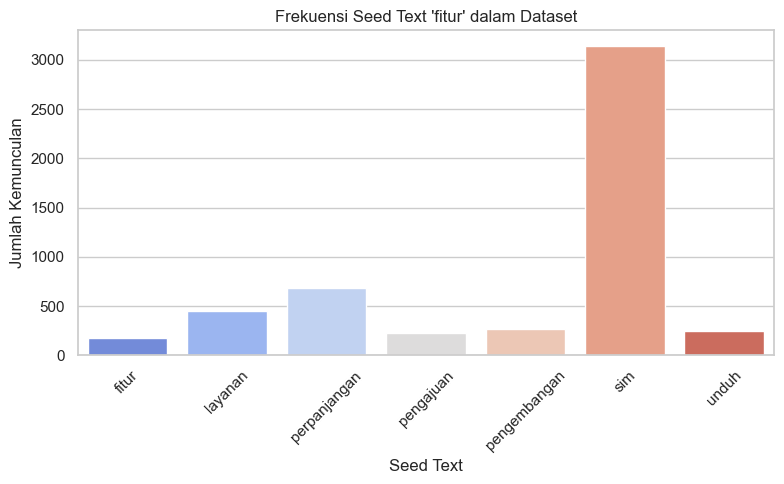

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


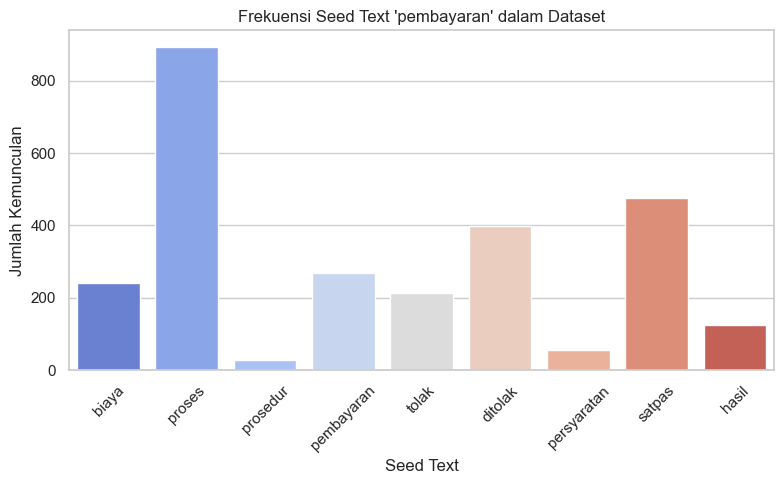

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


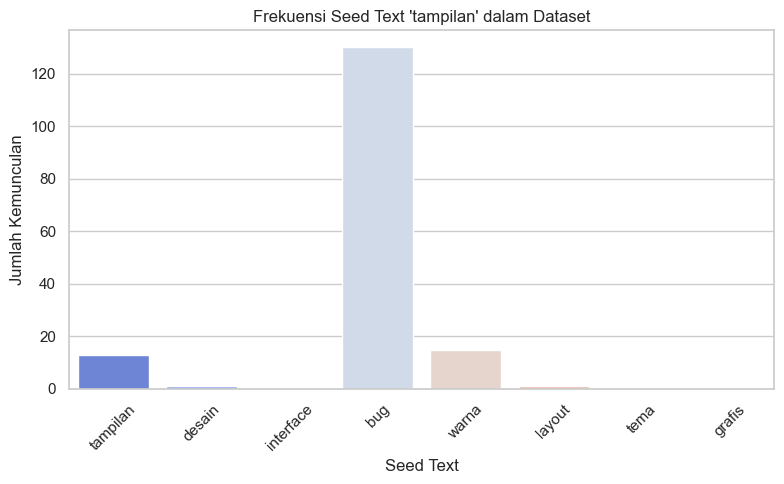

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


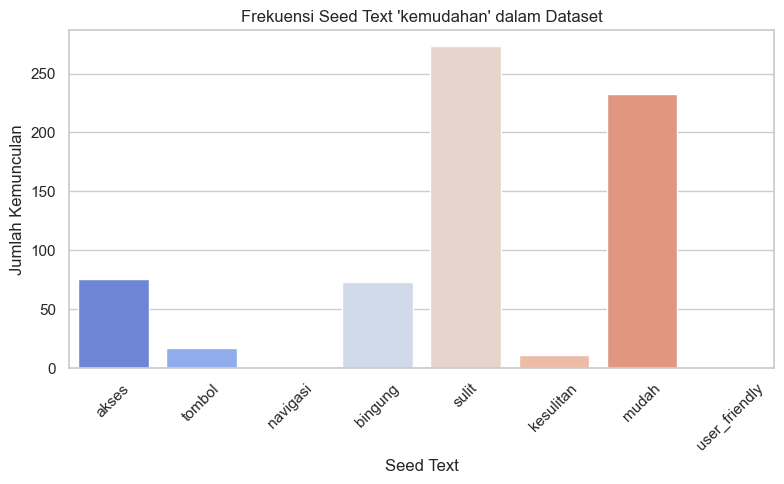

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


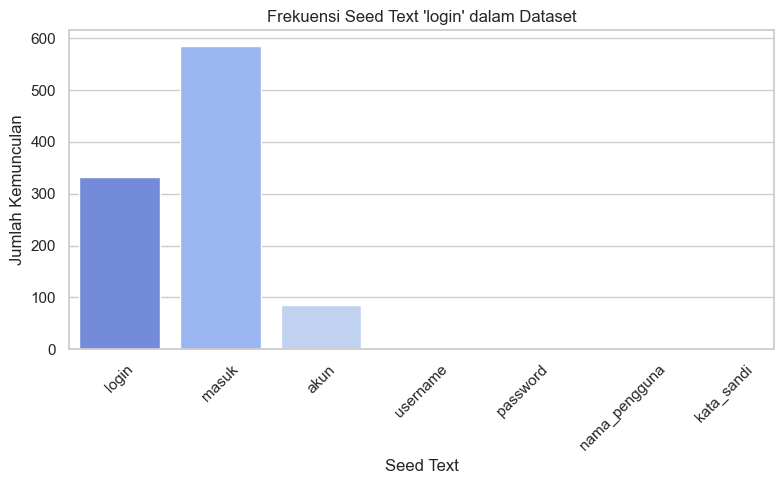

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


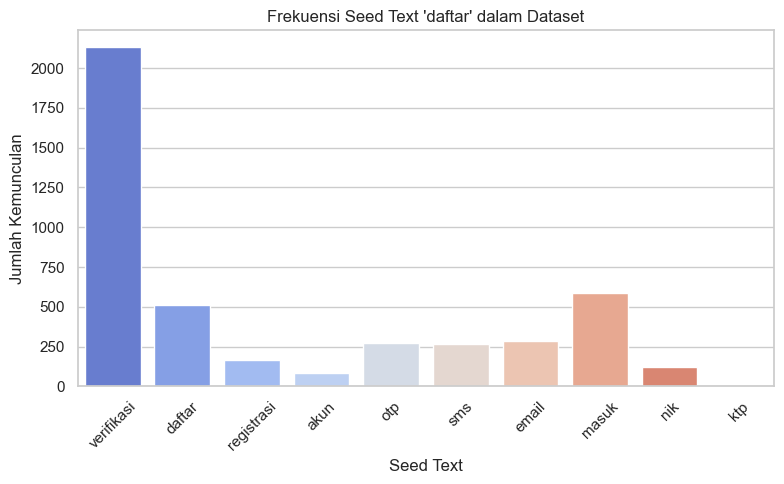

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\2664659564.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


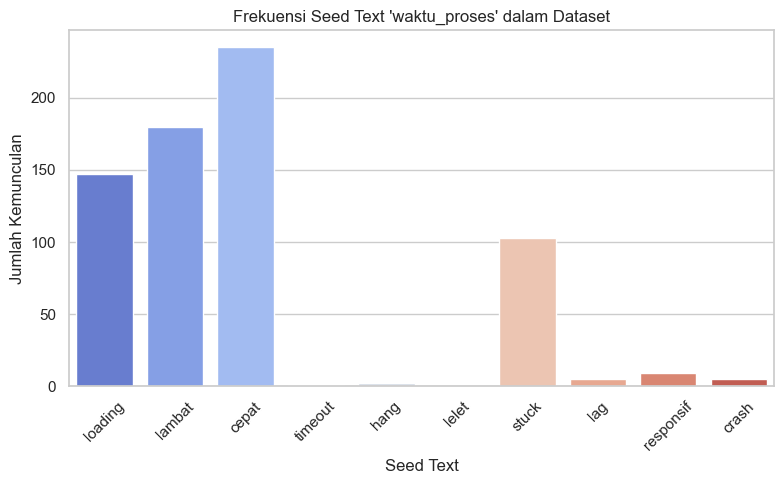

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

seed_categories = {
    "fitur":["fitur", "layanan", "perpanjangan", "pengajuan", "pengembangan", "sim", "unduh"],  # Content (fungsi aplikasi)
    "pembayaran":["biaya", "proses", "prosedur", "pembayaran", "tolak", "ditolak", "persyaratan", "satpas", "hasil"],  # Accuracy (kebijakan dan proses)
    "tampilan":["tampilan", "desain", "interface", "bug", "warna", "layout", "tema", "grafis"],  # Format (UI/UX)
    "kemudahan":["akses", "tombol", "navigasi", "bingung", "sulit", "kesulitan", "mudah", "user_friendly"],  # Ease of use
    "login":["login","masuk", "akun", "username", "password", "nama_pengguna", "kata_sandi"],  # Ease of use + Login issue
    "daftar":["verifikasi", "daftar", "registrasi", "akun", "otp", "sms", "email", "masuk", "nik", "ktp"],  # Ease of use + Registration issue
    "waktu_proses":["loading", "lambat", "cepat", "timeout", "hang", "lelet", "stuck", "lag", "responsif", "crash"],  # Timeliness
    # veriki = ["foto", "verifikasi_wajah", "kamera", "verifikasi_ktp", "nomor_telepon", "susah_banget", "error"],  # Tambahan dari topik LDA yang banyak menyebut masalah foto/verifikasi
}

for category, seed_words in seed_categories.items():
    seed_counts = {word: sum(word in stop_list for stop_list in data["stop_word"]) for word in seed_words}

    # Visualisasi
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")
    plt.xlabel("Seed Text")
    plt.ylabel("Jumlah Kemunculan")
    plt.title(f"Frekuensi Seed Text '{category}' dalam Dataset") 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


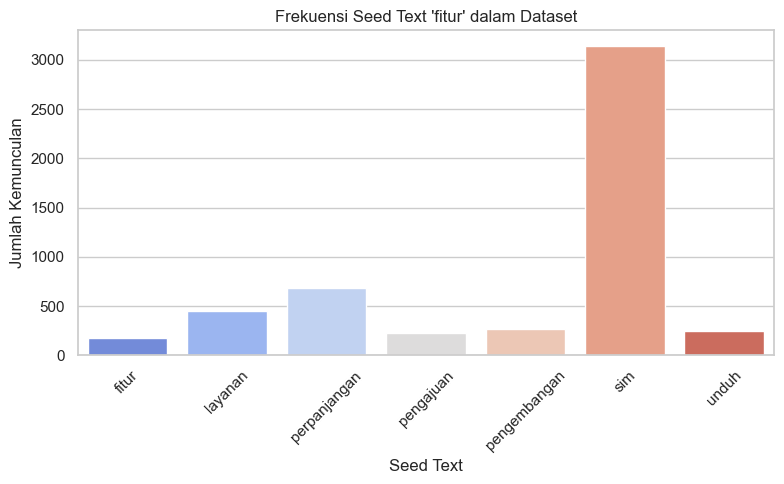

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


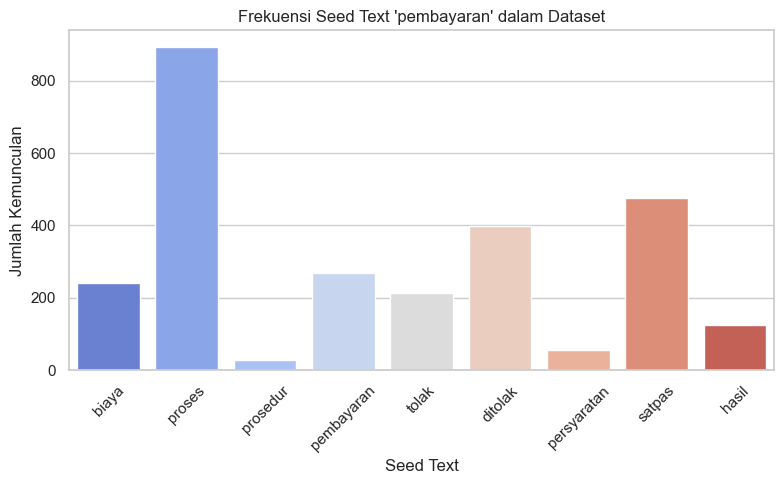

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


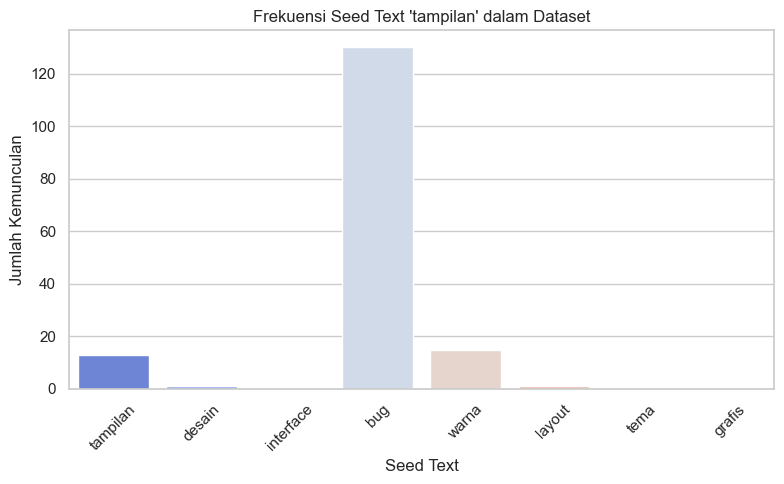

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


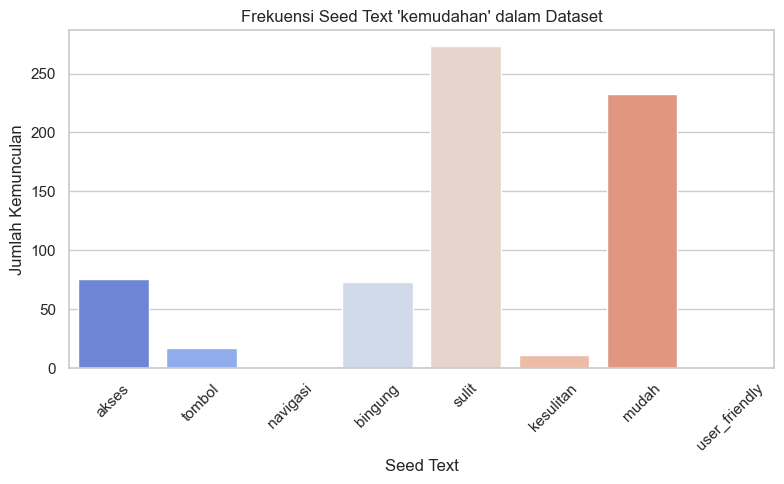

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


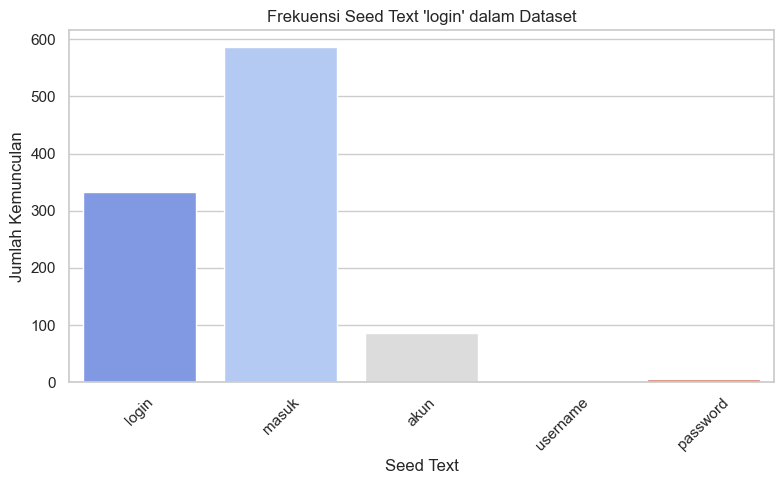

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


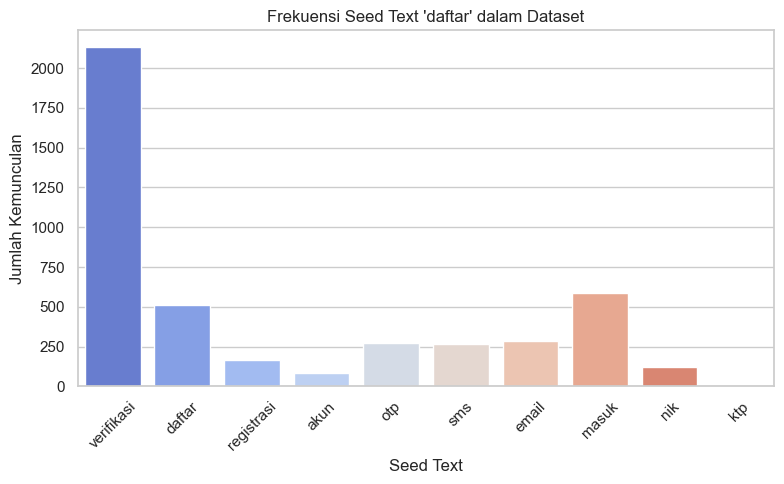

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1902168550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")


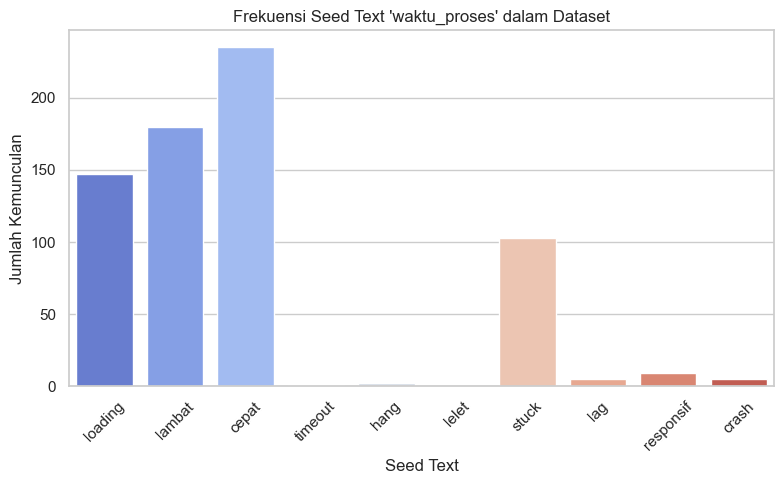

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

seed_categories = {
    # "Login & Pendaftaran": ["login", "verifikasi", "daftar", "registrasi", "akun", "otp", "sms", "verifikasi_wajah", "kartu_tanda_penduduk", "nik"], #Content
    # "Fitur Aplikasi": ["perpanjangan", "layanan", "sim", "fitur", "pengajuan", "unduh", "update", "pengembangan"], #Content
    # "Kebijakan & Proses": ["biaya", "proses", "prosedur", "hasil", "persyaratan", "ketentuan", "pembayaran", "tolak", "ditolak", "validasi", "satpas"], #Accuracy
    # "Tampilan & Desain": ["ui", "ux", "mudah", "susah", "tampilan", "bug", "layout", "warna", "design", "grafis", "tema", "interface", "desain"], #Format
    # "Aksesibilitas": ["bingung", "digunakan", "akses", "tombol", "button", "navigasi", "sulit", "kesulitan"], #Easy of use
    # "Kecepatan & Respons": ["cepat", "lambat", "loading", "respons", "lag", "timeout", "stuck", "hang", "lelet", "responsif", "crash", "timeout"] #Timeliness

    
    "fitur":["fitur", "layanan", "perpanjangan", "pengajuan", "pengembangan", "sim", "unduh"],  # Content (fungsi aplikasi)
    "pembayaran":["biaya", "proses", "prosedur", "pembayaran", "tolak", "ditolak", "persyaratan", "satpas", "hasil"],  # Accuracy (kebijakan dan proses)
    "tampilan":["tampilan", "desain", "interface", "bug", "warna", "layout", "tema", "grafis"],  # Format (UI/UX)
    "kemudahan":["akses", "tombol", "navigasi", "bingung", "sulit", "kesulitan", "mudah", "user_friendly"],  # Ease of use
    "login":["login","masuk", "akun", "username", "password"],  # Ease of use + Login issue
    "daftar":["verifikasi", "daftar", "registrasi", "akun", "otp", "sms", "email", "masuk", "nik", "ktp"],  # Ease of use + Registration issue
    "waktu_proses":["loading", "lambat", "cepat", "timeout", "hang", "lelet", "stuck", "lag", "responsif", "crash"],  # Timeliness
    # veriki = ["foto", "verifikasi_wajah", "kamera", "verifikasi_ktp", "nomor_telepon", "susah_banget", "error"],  # Tambahan dari topik LDA yang banyak menyebut masalah foto/verifikasi

}

for category, seed_words in seed_categories.items():
    seed_counts = {word: sum(word in stop_list for stop_list in data["stop_word"]) for word in seed_words}

    # Visualisasi
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(seed_counts.keys()), y=list(seed_counts.values()), palette="coolwarm")
    plt.xlabel("Seed Text")
    plt.ylabel("Jumlah Kemunculan")
    plt.title(f"Frekuensi Seed Text '{category}' dalam Dataset") 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [52]:
#Menyimpan seed word dengan vocab
login  = [x for x in login if x in list(word2id.keys())]
daftar  = [x for x in daftar if x in list(word2id.keys())]
fitur  = [x for x in fitur if x in list(word2id.keys())]
pembayaran  = [x for x in pembayaran if x in list(word2id.keys())]
tampilan  = [x for x in tampilan if x in list(word2id.keys())]
kemudahan = [x for x in kemudahan if x in list(word2id.keys())]
waktu_proses = [x for x in waktu_proses if x in list(word2id.keys())]

In [53]:
seed_topic_list = [
    fitur,
    pembayaran,
    tampilan,
    kemudahan,
    login,
    daftar,
    waktu_proses
]

In [ ]:
#Inisialisasi model
# model = glda.GuidedLDA(n_topics=7, n_iter=2000, random_state=42, refresh=20,alpha=0.01,eta=0.01)

In [54]:
#Inisialisasi topik list
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

# Training model jumlah topik terbaik

In [57]:
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:lda:n_documents: 11382
INFO:lda:vocab_size: 12507
INFO:lda:n_words: 89584
INFO:lda:n_topics: 7
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -1097285
INFO:lda:<20> log likelihood: -768699
INFO:lda:<40> log likelihood: -760175
INFO:lda:<60> log likelihood: -754563
INFO:lda:<80> log likelihood: -749522
INFO:lda:<100> log likelihood: -745264
INFO:lda:<120> log likelihood: -742274
INFO:lda:<140> log likelihood: -740186
INFO:lda:<160> log likelihood: -738826
INFO:lda:<180> log likelihood: -737125
INFO:lda:<200> log likelihood: -736214
INFO:lda:<220> log likelihood: -735196
INFO:lda:<240> log likelihood: -734157
INFO:lda:<260> log likelihood: -733232
INFO:lda:<280> log likelihood: -732853
INFO:lda:<300> log likelihood: -732084
INFO:lda:<320> log likelihood: -731970
INFO:lda:<340> log likelihood: -731150
INFO:lda:<360> log likelihood: -730649
INFO:lda:<380> log likelihood: -729894
INFO:lda:<400> log likelihood: -729463
INFO:lda:<420> log likelihood: -729564
INFO:lda:<440> log likeli

In [58]:
#Menampilkan hasil kata terbaik pada tiap topik
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: gagal aplikasi verifikasi_kartu_tanda_penduduk penduduk verifikasi_elektonik_kartu_tanda verifikasi susah verifikasi_wajah foto sulit
Topic 1: aplikasi sim satpas proses coba bayar pengiriman gagal error data
Topic 2: aplikasi sim gagal data coba susah aplikasinya masuk verifikasi kesalahan
Topic 3: aplikasi sim aplikasinya daftar pengembangan layanan_tersedia pakai sih jelas unduh
Topic 4: aplikasi online sim ditolak bayar ribet langsung offline lebih satpas
Topic 5: sim proses coba aplikasi prosesnya bayar perpanjangan_sim pembayaran perpanjang_sim diproses
Topic 6: aplikasi masuk gagal login daftar susah verifikasi sms otp coba


In [ ]:
import numpy as np

n_top_words = 10
topic_word = model.topic_word_  # shape: [n_topics, n_vocab]
for i, topic_dist in enumerate(topic_word):
    top_indices = np.argsort(topic_dist)[::-1][:n_top_words]
    top_words = np.array(vocab)[top_indices]
    top_scores = topic_dist[top_indices]
    
    print(f"Topic {i}:")
    for word, score in zip(top_words, top_scores):
        print(f"  {word}: {score:.4f}")


Topic 0:
  gagal: 0.0341
  aplikasi: 0.0334
  masuk: 0.0319
  login: 0.0230
  daftar: 0.0176
  susah: 0.0150
  verifikasi: 0.0147
  sms: 0.0134
  coba: 0.0127
  otp: 0.0107
Topic 1:
  aplikasi: 0.0308
  sim: 0.0169
  online: 0.0169
  ditolak: 0.0118
  bayar: 0.0111
  langsung: 0.0087
  lebih: 0.0085
  satpas: 0.0084
  ribet: 0.0080
  offline: 0.0069
Topic 2:
  sim: 0.0322
  proses: 0.0286
  coba: 0.0193
  aplikasi: 0.0137
  gagal: 0.0105
  pembayaran: 0.0089
  bayar: 0.0086
  data: 0.0085
  perpanjangan_sim: 0.0073
  perpanjang_sim: 0.0067
Topic 3:
  gagal: 0.0703
  verifikasi_kartu_tanda_penduduk: 0.0271
  penduduk: 0.0269
  verifikasi_elektonik_kartu_tanda: 0.0254
  aplikasi: 0.0247
  verifikasi: 0.0230
  susah: 0.0218
  verifikasi_wajah: 0.0199
  foto: 0.0150
  sulit: 0.0128
Topic 4:
  aplikasi: 0.0572
  sim: 0.0179
  gagal: 0.0106
  aplikasinya: 0.0103
  ribet: 0.0096
  pakai: 0.0073
  masyarakat: 0.0064
  kayak: 0.0064
  online: 0.0062
  tolong: 0.0061
Topic 5:
  aplikasi: 0.0688


In [61]:
# evaluasi model coherence c_V  dan u_mass
from gensim.models import CoherenceModel
# Membuat dictionary dan corpus untuk gensim
texts = data['stop_word'].tolist()  # Menggunakan kolom 'stop_word' yang berisi list kata
dictionary = corpora.Dictionary(texts)
# Menghitung coherence score
# Membuat model coherence
coherence_model_lda = CoherenceModel(
    topics=topic_word, 
    texts=texts, 
    dictionary=dictionary, 
    coherence='c_v'  # Metode yang umum digunakan: 'c_v', 'u_mass', 'c_uci', atau 'c_npmi'
)

# Menghitung nilai coherence
coherence_score = coherence_model_lda.get_coherence()

print(f"Coherence Score: {coherence_score}")


INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<10020 unique tokens: ['anggap', 'bank', 'data', 'dikirim', 'gagal']...>
INFO:gensim.corpora.dictionary:built Dictionary<10856 unique tokens: ['anggap', 'bank', 'data', 'dikirim', 'gagal']...> from 11382 documents (total 111270 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<10856 unique tokens: ['anggap', 'bank', 'data', 'dikirim', 'gagal']...> from 11382 documents (total 111270 corpus positions)", 'datetime': '2025-06-10T22:44:57.271478', 'gensim': '4.3.3', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


ValueError: unable to interpret topic as either a list of tokens or a list of ids

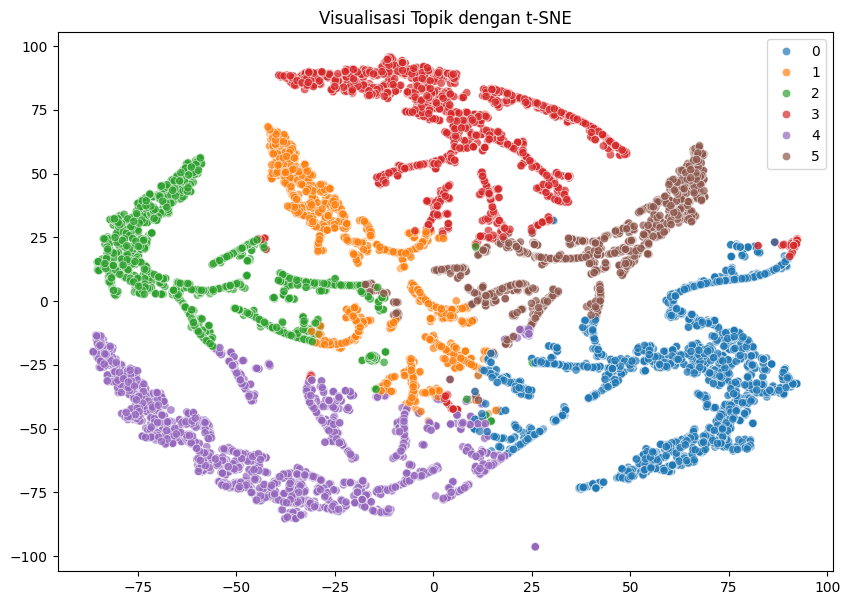

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Ubah distribusi dokumen-topik ke format 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne.fit_transform(model.transform(X))

# Buat plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=np.argmax(model.transform(X), axis=1), palette="tab10", alpha=0.7)
plt.title("Visualisasi Topik dengan t-SNE")
plt.show()


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\3589609940.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


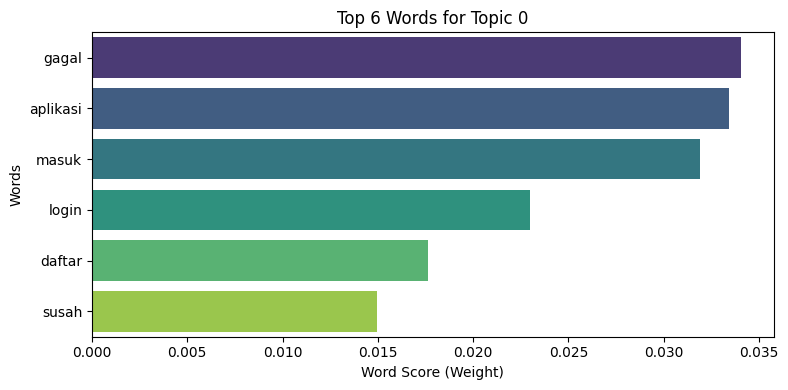

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\3589609940.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


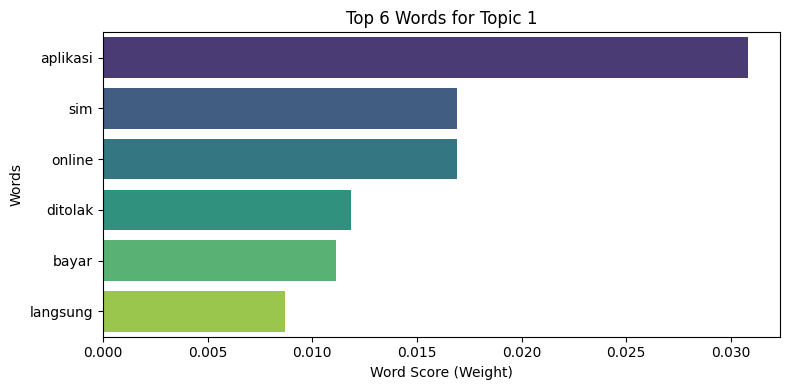

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\3589609940.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


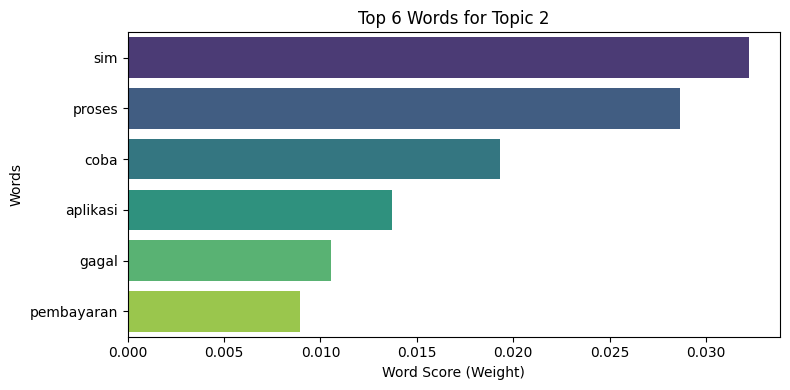

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\3589609940.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


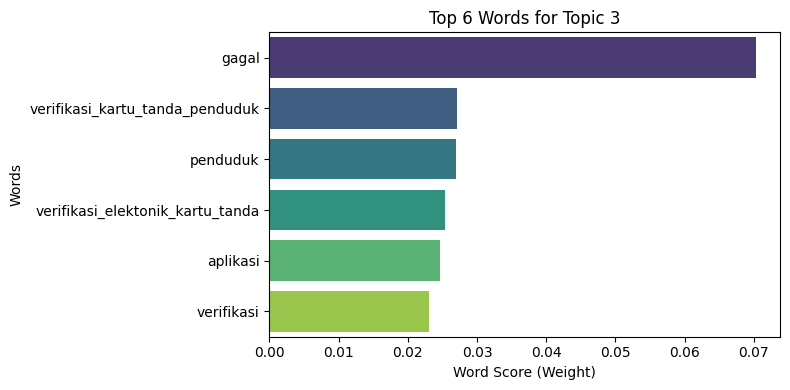

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\3589609940.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


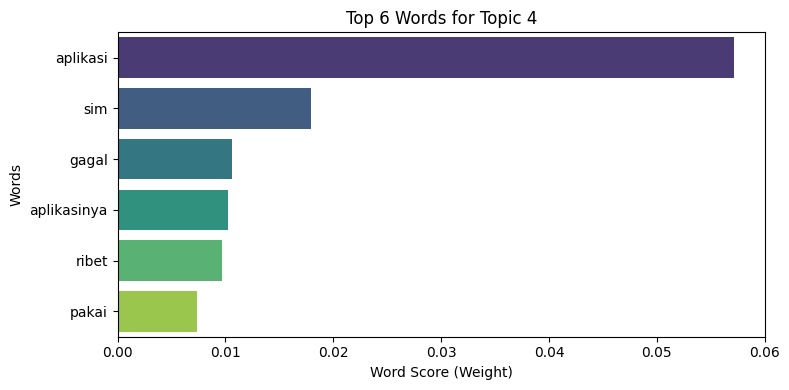

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\3589609940.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


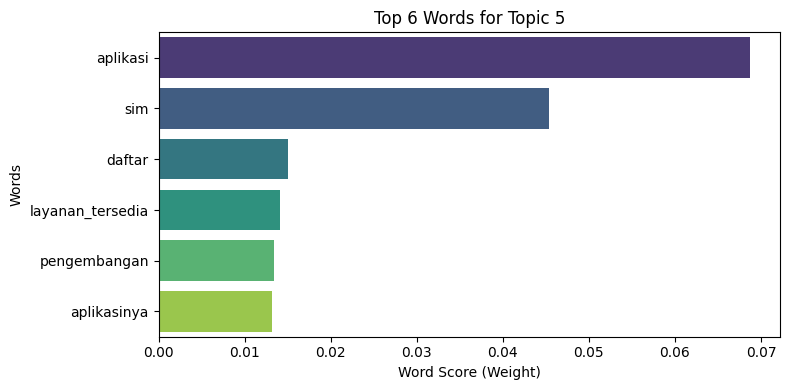

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi
n_top_words = 6  # Jumlah kata teratas per topik
topic_word = model.topic_word_  # matriks [n_topic x n_vocab]
n_topics = topic_word.shape[0]

# Plot
for i in range(n_topics):
    top_indices = np.argsort(topic_word[i])[::-1][:n_top_words]
    top_words = np.array(vocab)[top_indices]
    top_scores = topic_word[i][top_indices]
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_scores, y=top_words, palette="viridis")
    plt.title(f"Top {n_top_words} Words for Topic {i}")
    plt.xlabel("Word Score (Weight)")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_3804\169998902.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(topic_counts)), y=topic_counts, palette="coolwarm")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


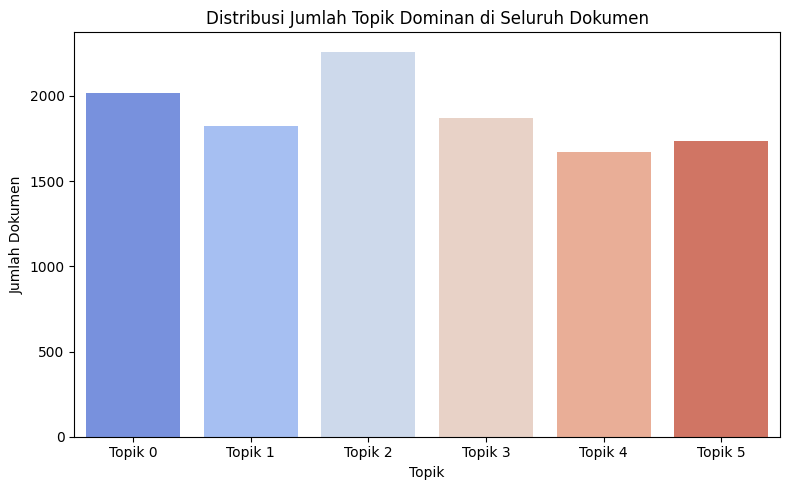

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil topik dominan tiap dokumen
doc_topic_dist = model.doc_topic_  # [n_docs x n_topics]
dominant_topics = np.argmax(doc_topic_dist, axis=1)

# Hitung jumlah dokumen per topik
topic_counts = np.bincount(dominant_topics)

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(x=np.arange(len(topic_counts)), y=topic_counts, palette="coolwarm")
plt.xlabel("Topik")
plt.ylabel("Jumlah Dokumen")
plt.title("Distribusi Jumlah Topik Dominan di Seluruh Dokumen")
plt.xticks(np.arange(len(topic_counts)))
plt.xticks(range(len(topic_counts)), [f'Topik {i}' for i in range(len(topic_counts))])
plt.tight_layout()
plt.show()


In [ ]:
# doc_topic = model.transform(X)
# for i in range(9):
#     print("top topic: {} Document: {}".format(doc_topic[i].argmax(),', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:5]]))))

# menemukan jumlah topik optimal

In [55]:
from lda import guidedlda as glda
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import numpy as np
import pandas as pd

from tqdm import tqdm

In [56]:
def compute_coherence_values(topics, texts, dictionary, corpus):
    coherence_cv = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_umass = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, corpus=corpus, coherence='u_mass').get_coherence()
    return coherence_cv, coherence_umass


In [57]:
import pickle

In [58]:
results = []
topic_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]  # contoh range jumlah topik

for n_topics in tqdm(topic_range):
    model = glda.GuidedLDA(n_topics=n_topics, n_iter=2000, random_state=42, refresh=20, alpha=0.01, eta=0.01)
    
    # Inisialisasi seed_topics ulang
    seed_topics = {}
    for t_id, seed_words in enumerate(seed_topic_list[:n_topics]):  # pastikan jumlah seed_words <= n_topics
        for word in seed_words:
            if word in word2id:
                seed_topics[word2id[word]] = t_id

    # Fit model
    model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

    # Ambil top words dari model
    topic_word = model.topic_word_
    top_words = []
    for i in range(n_topics):
        top = np.array(vocab)[np.argsort(topic_word[i])][:-11:-1]
        top_words.append(top.tolist())

    # Siapkan data untuk evaluasi coherence
    tokenized_texts = data['stop_word'].tolist()  # jika kolom stop_word sudah berupa list of tokens
    dictionary = Dictionary(tokenized_texts)  # `tokenized_texts` = list of token list (contoh: [["fitur", "sim"], ...])
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Hitung coherence
    coherence_cv, coherence_umass = compute_coherence_values(top_words, tokenized_texts, dictionary, corpus)

    # Simpan hasil
    results.append({
        "n_topics": n_topics,
        "log_likelihood": model.loglikelihood(),
        "coherence_cv": coherence_cv,
        "coherence_umass": coherence_umass
    })

    #menyimpan model
    with open(f"model_glda/glda_model_{n_topics}_topics.pkl", "wb") as f:
        pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
    # menyiman vectorizer
    with open(f"model_glda/vectorizer_{n_topics}_topics.pkl", "wb") as f:
        pickle.dump(vectorizer, f, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/9 [00:00<?, ?it/s]INFO:lda:n_documents: 11382
INFO:lda:vocab_size: 12507
INFO:lda:n_words: 89584
INFO:lda:n_topics: 2
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -841481
INFO:lda:<20> log likelihood: -740706
INFO:lda:<40> log likelihood: -737255
INFO:lda:<60> log likelihood: -735900
INFO:lda:<80> log likelihood: -734792
INFO:lda:<100> log likelihood: -732912
INFO:lda:<120> log likelihood: -732172
INFO:lda:<140> log likelihood: -731499
INFO:lda:<160> log likelihood: -730280
INFO:lda:<180> log likelihood: -728793
INFO:lda:<200> log likelihood: -727850
INFO:lda:<220> log likelihood: -726429
INFO:lda:<240> log likelihood: -725264
INFO:lda:<260> log likelihood: -724096
INFO:lda:<280> log likelihood: -723606
INFO:lda:<300> log likelihood: -723072
INFO:lda:<320> log likelihood: -722624
INFO:lda:<340> log likelihood: -722310
INFO:lda:<360> log likelihood: -722319
INFO:lda:<380> log likelihood: -722036
INFO:lda:<400> log likelihood: -721838
INFO:lda:<420> log likelihoo

In [60]:
results_df = pd.DataFrame(results)
print(results_df)


   n_topics  log_likelihood  coherence_cv  coherence_umass
0         2  -721134.429447      0.432925        -2.364094
1         3  -722447.441833      0.492099        -2.537363
2         4  -723798.425148      0.530438        -2.310446
3         5  -723119.426989      0.520041        -2.405889
4         6  -722979.051212      0.529929        -2.525474
5         7  -724185.700991      0.530860        -2.506399
6         8  -724772.879990      0.514624        -2.556599
7         9  -723726.519804      0.529948        -2.579916
8        10  -724338.537696      0.534591        -2.628516


In [61]:
results_df

,n_topics,log_likelihood,coherence_cv,coherence_umass
0,2,-721134.429447,0.432925,-2.364094
1,3,-722447.441833,0.492099,-2.537363
2,4,-723798.425148,0.530438,-2.310446
3,5,-723119.426989,0.520041,-2.405889
4,6,-722979.051212,0.529929,-2.525474
5,7,-724185.700991,0.530860,-2.506399
6,8,-724772.879990,0.514624,-2.556599
7,9,-723726.519804,0.529948,-2.579916
8,10,-724338.537696,0.534591,-2.628516


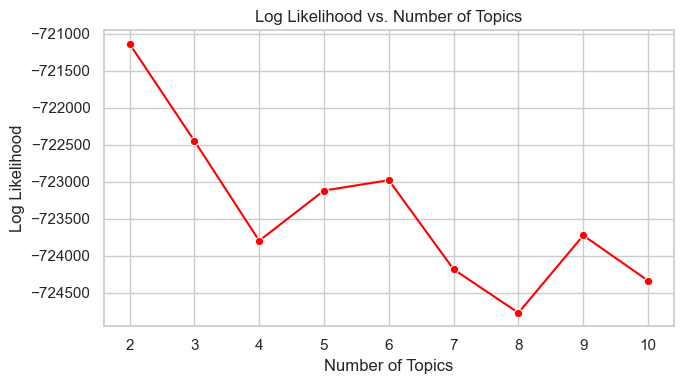

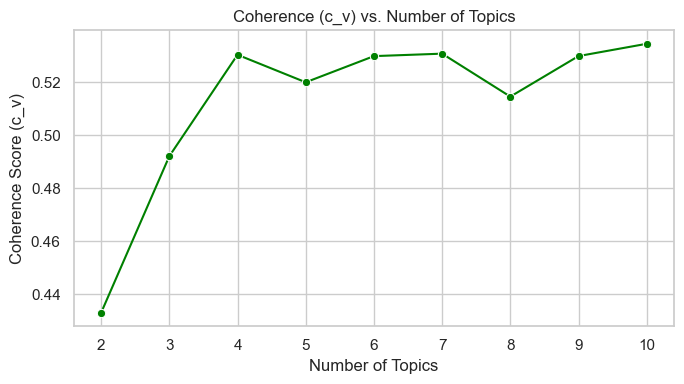

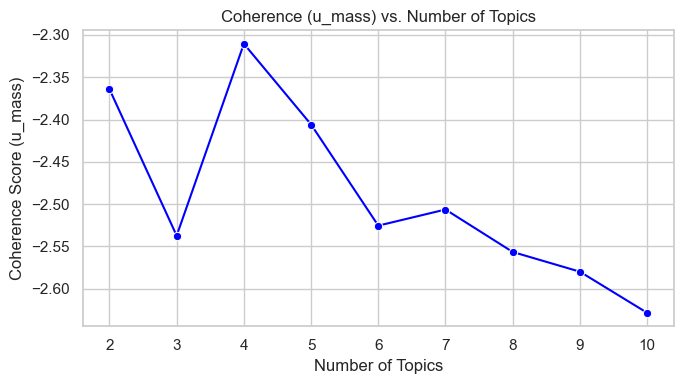

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set style
sns.set(style="whitegrid")

# Plot 1: Log Likelihood
plt.figure(figsize=(7, 4))
sns.lineplot(x="n_topics", y="log_likelihood", data=results_df, marker="o", color="red")
plt.title("Log Likelihood vs. Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Log Likelihood")
plt.tight_layout()
plt.show()

# Plot 2: Coherence c_v
plt.figure(figsize=(7, 4))
sns.lineplot(x="n_topics", y="coherence_cv", data=results_df, marker="o", color="green")
plt.title("Coherence (c_v) vs. Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.tight_layout()
plt.show()

# Plot 3: Coherence u_mass
plt.figure(figsize=(7, 4))
sns.lineplot(x="n_topics", y="coherence_umass", data=results_df, marker="o", color="blue")
plt.title("Coherence (u_mass) vs. Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (u_mass)")
plt.tight_layout()
plt.show()


# Training dengan jumlah topik terbaik

In [62]:
model = glda.GuidedLDA(n_topics=7, n_iter=2000, random_state=42, refresh=20, alpha=0.01, eta=0.01)

In [63]:
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:lda:n_documents: 11382
INFO:lda:vocab_size: 12507
INFO:lda:n_words: 89584
INFO:lda:n_topics: 7
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -1097285
INFO:lda:<20> log likelihood: -768699
INFO:lda:<40> log likelihood: -760175
INFO:lda:<60> log likelihood: -754563
INFO:lda:<80> log likelihood: -749522
INFO:lda:<100> log likelihood: -745264
INFO:lda:<120> log likelihood: -742274
INFO:lda:<140> log likelihood: -740186
INFO:lda:<160> log likelihood: -738826
INFO:lda:<180> log likelihood: -737125
INFO:lda:<200> log likelihood: -736214
INFO:lda:<220> log likelihood: -735196
INFO:lda:<240> log likelihood: -734157
INFO:lda:<260> log likelihood: -733232
INFO:lda:<280> log likelihood: -732853
INFO:lda:<300> log likelihood: -732084
INFO:lda:<320> log likelihood: -731970
INFO:lda:<340> log likelihood: -731150
INFO:lda:<360> log likelihood: -730649
INFO:lda:<380> log likelihood: -729894
INFO:lda:<400> log likelihood: -729463
INFO:lda:<420> log likelihood: -729564
INFO:lda:<440> log likeli

In [64]:
# menampilkan hasil kata terbaik pada tiap topik
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: gagal aplikasi verifikasi_kartu_tanda_penduduk penduduk verifikasi_elektonik_kartu_tanda verifikasi susah verifikasi_wajah foto sulit
Topic 1: aplikasi sim satpas proses coba bayar pengiriman gagal error data
Topic 2: aplikasi sim gagal data coba susah aplikasinya masuk verifikasi kesalahan
Topic 3: aplikasi sim aplikasinya daftar pengembangan layanan_tersedia pakai sih jelas unduh
Topic 4: aplikasi online sim ditolak bayar ribet langsung offline lebih satpas
Topic 5: sim proses coba aplikasi prosesnya bayar perpanjangan_sim pembayaran perpanjang_sim diproses
Topic 6: aplikasi masuk gagal login daftar susah verifikasi sms otp coba


# Menampilkan output pada jumlah topik optimal

In [63]:
# load model dan vectorizer (disesuaikan dengan nama file yang telah disimpan)
import pickle
with open("model_glda/glda_model_7_topics.pkl", "rb") as f:
    model = pickle.load(f)
with open("model_glda/vectorizer_7_topics.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# menampilkan hasil kata terbaik pada tiap topik
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))


Topic 0: aplikasi gagal aplikasinya susah sim masuk jelas verifikasi ribet pakai
Topic 1: aplikasi sim online daftar layanan_tersedia pengembangan ribet pakai masyarakat sim_online
Topic 2: aplikasi sim gagal data coba proses pas online perpanjangan_sim satpas
Topic 3: gagal verifikasi_kartu_tanda_penduduk verifikasi_elektonik_kartu_tanda penduduk aplikasi verifikasi susah verifikasi_wajah coba foto
Topic 4: gagal aplikasi masuk login daftar verifikasi sms susah coba email
Topic 5: sim proses coba aplikasi bayar prosesnya perpanjang_sim perpanjangan_sim pembayaran tanggal
Topic 6: aplikasi sim ditolak online foto bayar satpas jelas langsung uang


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10828\1143175628.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(topic_counts)), y=topic_counts, palette="tab10")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


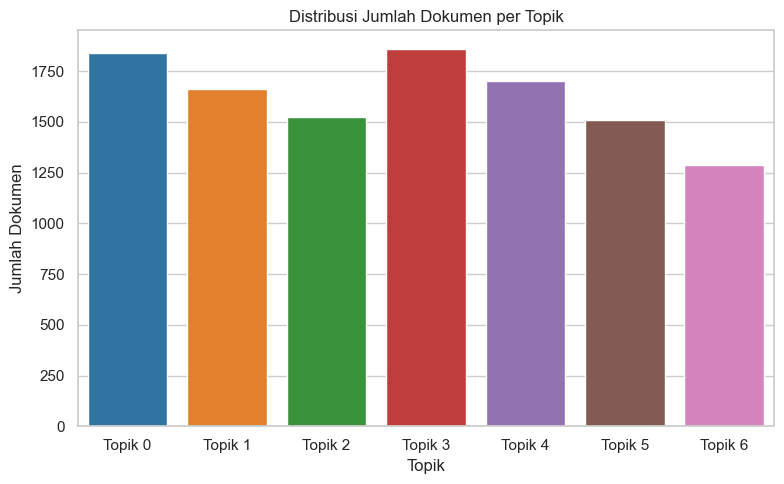

In [66]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Ambil distribusi topik dominan untuk setiap dokumen
doc_topic_dist = model.doc_topic_  # shape: [n_docs, n_topics]
dominant_topics = np.argmax(doc_topic_dist, axis=1)

# Hitung jumlah dokumen per topik
topic_counts = np.bincount(dominant_topics, minlength=doc_topic_dist.shape[1])

# Visualisasi distribusi topik
plt.figure(figsize=(8, 5))
sns.barplot(x=np.arange(len(topic_counts)), y=topic_counts, palette="tab10")
plt.xlabel("Topik")
plt.ylabel("Jumlah Dokumen")
plt.title("Distribusi Jumlah Dokumen per Topik")
plt.xticks(np.arange(len(topic_counts)), [f"Topik {i}" for i in range(len(topic_counts))])
plt.tight_layout()
plt.show()

# Evaluasi

In [65]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [66]:
#Menyimpan hasil topik kedalam dictionary
n_top_words = 7
topic_word = model.topic_word_
topics = [
    [vocab[i] for i in np.argsort(topic_dist)[:-n_top_words-1:-1]]
    for topic_dist in topic_word
]
print(topics)

[['gagal', 'aplikasi', 'verifikasi_kartu_tanda_penduduk', 'penduduk', 'verifikasi_elektonik_kartu_tanda', 'verifikasi', 'susah'], ['aplikasi', 'sim', 'satpas', 'proses', 'coba', 'bayar', 'pengiriman'], ['aplikasi', 'sim', 'gagal', 'data', 'coba', 'susah', 'aplikasinya'], ['aplikasi', 'sim', 'aplikasinya', 'daftar', 'pengembangan', 'layanan_tersedia', 'pakai'], ['aplikasi', 'online', 'sim', 'ditolak', 'bayar', 'ribet', 'langsung'], ['sim', 'proses', 'coba', 'aplikasi', 'prosesnya', 'bayar', 'perpanjangan_sim'], ['aplikasi', 'masuk', 'gagal', 'login', 'daftar', 'susah', 'verifikasi']]


In [77]:
#Menampilkan hasil kata terbaik pada tiap topik
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: gagal penduduk verifikasi_elektonik_kartu_tanda verifikasi_kartu_tanda_penduduk verifikasi_wajah verifikasi aplikasi susah foto sulit
Topic 1: sim gagal aplikasi data email susah login verifikasi masuk daftar
Topic 2: aplikasi masuk gagal login sms susah verifikasi daftar otp coba
Topic 3: sim satpas pengiriman proses alamat aplikasi data pas error eror
Topic 4: aplikasi sim gagal aplikasinya foto bagus membantu sistem terima_kasih pembaruan
Topic 5: aplikasi sim masuk coba daftar aplikasinya gagal loading sih buka
Topic 6: proses sim coba aplikasi prosesnya bayar pembayaran diproses tanggal perpanjangan_sim
Topic 7: aplikasi sim pakai unduh pengembangan aplikasinya layanan_tersedia jelas masyarakat tolong
Topic 8: aplikasi ditolak sim bayar tolak satpas foto online jelas gagal
Topic 9: aplikasi online ribet sim tes_kesehatan lebih offline langsung tes pakai


In [68]:
#Membuat texts
texts = data['stop_word'].tolist()

In [69]:
# Membuat dictionary untuk coherence model
dictionary = gensim.corpora.Dictionary(texts)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<10020 unique tokens: ['anggap', 'bank', 'data', 'dikirim', 'gagal']...>
INFO:gensim.corpora.dictionary:built Dictionary<10856 unique tokens: ['anggap', 'bank', 'data', 'dikirim', 'gagal']...> from 11382 documents (total 111270 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<10856 unique tokens: ['anggap', 'bank', 'data', 'dikirim', 'gagal']...> from 11382 documents (total 111270 corpus positions)", 'datetime': '2025-06-10T22:47:56.994691', 'gensim': '4.3.3', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [70]:
# Membuat model coherence
coherence_model_lda = CoherenceModel(
    topics=topics, 
    texts=texts, 
    dictionary=dictionary, 
    coherence='c_v'  # Metode yang umum digunakan: 'c_v', 'u_mass', 'c_uci', atau 'c_npmi'
)

# Menghitung nilai coherence
coherence_score = coherence_model_lda.get_coherence()

print(f"Coherence Score: {coherence_score}")

INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator<processes=3, batch_size=64> to estimate probabilities from sliding windows


INFO:gensim.topic_coherence.text_analysis:3 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 11382 virtual documents


Coherence Score: 0.5498615770636031


In [71]:
# Membuat model coherence
coherence_model_lda = CoherenceModel(
    topics=topics, 
    texts=texts, 
    dictionary=dictionary, 
    coherence='u_mass'  # Metode yang umum digunakan: 'c_v', 'u_mass', 'c_uci', atau 'c_npmi'
)

# Menghitung nilai coherence
coherence_score = coherence_model_lda.get_coherence()

print(f"Coherence Score: {coherence_score}")

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 5000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 6000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 7000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 8000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 9000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 10000 documents
INFO:gensim.topic_c

Coherence Score: -2.35904810826871


In [ ]:
#visualisasi
nilai = []

# menyimpan model

In [42]:
import pickle

with open("models/glda_model-rev.pkl", "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
with open("models/vectorizer-rev.pkl", "wb") as f:
    pickle.dump(vectorizer, f,protocol=pickle.HIGHEST_PROTOCOL)


# menyimpan hasil 

In [44]:
seed_topic_dict = {
    "Login": [],
    "Daftar": [],
    "Fitur aplikasi" : [],
    "Pembayaran" : [],
    "Tampilan" : [],
    "Kemudahan" : [],
    "Waktu proses" : []
}#disesuaikan dengan format data input library matplotlib, MAX hnaya 6 aspek dan masing2 ada max 6 sub topik

In [45]:
# Mengisi dictionary dengan top-kata dari tiap topik
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    seed_topic_dict[list(seed_topic_dict.keys())[i]] = list(topic_words)

IndexError: list index out of range

In [ ]:
# Menampilkan hasil
print(seed_topic_dict)

{'Login & Pendaftaran': ['gagal', 'aplikasi', 'masuk', 'login', 'daftar', 'susah'], 'Fitur Aplikasi': ['aplikasi', 'sim', 'online', 'ditolak', 'bayar', 'langsung'], 'Kebijakan & Proses': ['sim', 'proses', 'coba', 'aplikasi', 'gagal', 'pembayaran'], 'Tampilan & Desain': ['gagal', 'verifikasi_kartu_tanda_penduduk', 'penduduk', 'verifikasi_elektonik_kartu_tanda', 'aplikasi', 'verifikasi'], 'Aksesibilitas': ['aplikasi', 'sim', 'gagal', 'aplikasinya', 'ribet', 'pakai'], 'Kecepatan & Respons': ['aplikasi', 'sim', 'daftar', 'layanan_tersedia', 'pengembangan', 'aplikasinya']}


In [ ]:
seed_topic_dict

{'Login & Pendaftaran': ['gagal',
  'aplikasi',
  'masuk',
  'login',
  'daftar',
  'susah'],
 'Fitur Aplikasi': ['aplikasi',
  'sim',
  'online',
  'ditolak',
  'bayar',
  'langsung'],
 'Kebijakan & Proses': ['sim',
  'proses',
  'coba',
  'aplikasi',
  'gagal',
  'pembayaran'],
 'Tampilan & Desain': ['gagal',
  'verifikasi_kartu_tanda_penduduk',
  'penduduk',
  'verifikasi_elektonik_kartu_tanda',
  'aplikasi',
  'verifikasi'],
 'Aksesibilitas': ['aplikasi',
  'sim',
  'gagal',
  'aplikasinya',
  'ribet',
  'pakai'],
 'Kecepatan & Respons': ['aplikasi',
  'sim',
  'daftar',
  'layanan_tersedia',
  'pengembangan',
  'aplikasinya']}

In [ ]:
import json

# Simpan ke file JSON
with open("hasil_topik_glda0.55.json", "w") as f:
    json.dump(seed_topic_dict, f, indent=4)
